In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [2]:
# Step 1: Dataset Preparation
# Load the Air Passengers dataset
data = pd.read_csv('/content/AirPassengers.csv')
# Parse dates and set 'Month' column as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
# Split data into training and test sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences and labels
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Define sequence length
seq_length = 12  # Using data from previous 12 months to predict the next month

# Create sequences and labels for training and test sets
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)



In [3]:

# Step 2: Model Architecture
model = Sequential([
    LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:

# Step 3: Model Training
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=2)


Epoch 1/100
7/7 - 9s - 1s/step - loss: 0.0499 - val_loss: 0.1003
Epoch 2/100
7/7 - 1s - 89ms/step - loss: 0.0117 - val_loss: 0.0218
Epoch 3/100
7/7 - 0s - 18ms/step - loss: 0.0121 - val_loss: 0.0221
Epoch 4/100
7/7 - 0s - 13ms/step - loss: 0.0084 - val_loss: 0.0312
Epoch 5/100
7/7 - 0s - 13ms/step - loss: 0.0075 - val_loss: 0.0340
Epoch 6/100
7/7 - 0s - 21ms/step - loss: 0.0082 - val_loss: 0.0255
Epoch 7/100
7/7 - 0s - 13ms/step - loss: 0.0073 - val_loss: 0.0230
Epoch 8/100
7/7 - 0s - 15ms/step - loss: 0.0073 - val_loss: 0.0229
Epoch 9/100
7/7 - 0s - 15ms/step - loss: 0.0078 - val_loss: 0.0225
Epoch 10/100
7/7 - 0s - 19ms/step - loss: 0.0086 - val_loss: 0.0237
Epoch 11/100
7/7 - 0s - 14ms/step - loss: 0.0066 - val_loss: 0.0229
Epoch 12/100
7/7 - 0s - 21ms/step - loss: 0.0068 - val_loss: 0.0223
Epoch 13/100
7/7 - 0s - 17ms/step - loss: 0.0070 - val_loss: 0.0226
Epoch 14/100
7/7 - 0s - 17ms/step - loss: 0.0076 - val_loss: 0.0229
Epoch 15/100
7/7 - 0s - 15ms/step - loss: 0.0074 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
MAE: 39.0710251752068
RMSE: 47.70813270115171


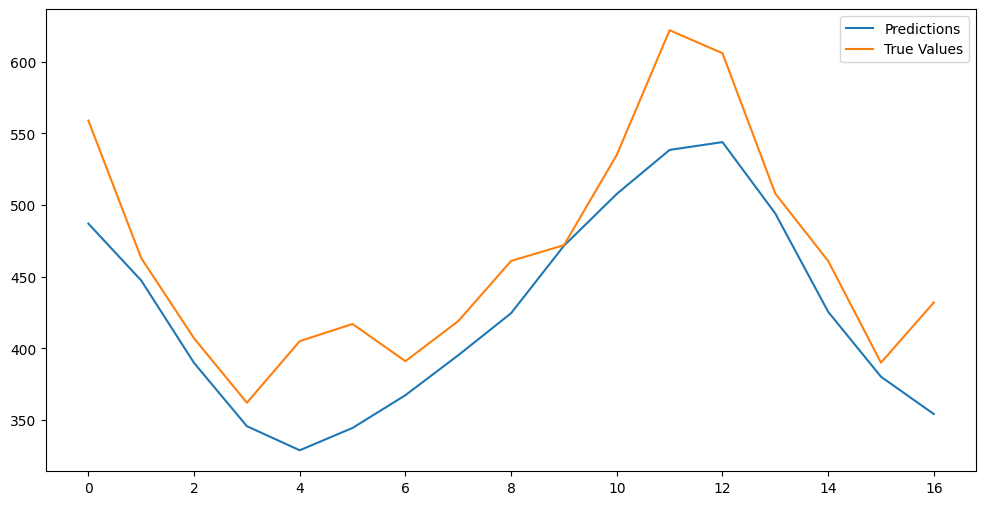

In [5]:

# Step 4: Model Evaluation
def evaluate_model(model, X_test, y_test):
    # Make predictions
    predictions = model.predict(X_test)
    # Invert scaling for forecast
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)
    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('MAE:', mae)
    print('RMSE:', rmse)
    # Visualize predictions vs ground truth
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predictions')
    plt.plot(y_test, label='True Values')
    plt.legend()
    plt.show()


evaluate_model(model, X_test, y_test)


In [13]:
!pip install scikeras

# step 5: Hyper Parameter Tuning

In [25]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import numpy as np
from sklearn.metrics import mean_squared_error

class KerasLSTM(BaseEstimator):
    """Wrapper class for the LSTM model to make it compatible with scikit-learn."""

    def __init__(self, units=50, dropout_rate=0.2, learning_rate=0.001):
        """Initialize the model with hyperparameters."""
        self.units = units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """Fit the model to the training data."""
        model = Sequential([
            LSTM(units=self.units, input_shape=(X.shape[1], X.shape[2])),
            Dropout(self.dropout_rate),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        self.model = model.fit(X, y, epochs=10, batch_size=32, verbose=0)  # Adjust epochs and batch_size as needed
        return self

    def predict(self, X):
        """Make predictions on the test data."""
        return self.model.model.predict(X)

# Define hyperparameters to tune
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Create an instance of the wrapper class
keras_lstm = KerasLSTM()

# Perform grid search
grid_search = GridSearchCV(estimator=keras_lstm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_result = grid_search.fit(X_train, y_train)

# Print results
print("Best parameters found: ", grid_result.best_params_)
print("Lowest RMSE found: ", np.sqrt(-grid_result.best_score_))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.001, units=50; total time=   4.7s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.001, units=50; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ....dropout_rate=0.1, learning_rate=0.001, units=50; total time=   2.7s
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
[CV] END ...dropout_rate=0.1, learning_rate=0.001, units=100; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[CV] END ...dropout_rate=0.1, learning_rate=0.001, units=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[CV] END ...dropout_rate=0.1, learning_rate=0.001, units=100; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
[CV] END ...dropout_rate=0.1, learning_rate=0.001, units=150; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
[CV] END ...dropout_rate=0.1, learning_rate=0.001, units=150; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[CV] END ...dropout_rate=0.1, learning_rate=0.001, units=150; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.01, units=50; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.01, units=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.01, units=50; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.01, units=100; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.01, units=100; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.01, units=100; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.01, units=150; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.01, units=150; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
[CV] END ....dropout_rate=0.1, learning_rate=0.01, units=150; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
[CV] END ......dropout_rate=0.1, learning_rate=0.1, units=50; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
[CV] END ......dropout_rate=0.1, learning_rate=0.1, units=50; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
[CV] END ......dropout_rate=0.1, learning_rate=0.1, units=50; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.1, units=100; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.1, units=100; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.1, units=100; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.1, units=150; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.1, units=150; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
[CV] END .....dropout_rate=0.1, learning_rate=0.1, units=150; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.001, units=50; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.001, units=50; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.001, units=50; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[CV] END ...dropout_rate=0.2, learning_rate=0.001, units=100; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
[CV] END ...dropout_rate=0.2, learning_rate=0.001, units=100; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[CV] END ...dropout_rate=0.2, learning_rate=0.001, units=100; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
[CV] END ...dropout_rate=0.2, learning_rate=0.001, units=150; total time=   3.7s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
[CV] END ...dropout_rate=0.2, learning_rate=0.001, units=150; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
[CV] END ...dropout_rate=0.2, learning_rate=0.001, units=150; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.01, units=50; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.01, units=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.01, units=50; total time=   5.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.01, units=100; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.01, units=100; total time=   8.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.01, units=100; total time=   4.8s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.01, units=150; total time=   3.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.01, units=150; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
[CV] END ....dropout_rate=0.2, learning_rate=0.01, units=150; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
[CV] END ......dropout_rate=0.2, learning_rate=0.1, units=50; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
[CV] END ......dropout_rate=0.2, learning_rate=0.1, units=50; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
[CV] END ......dropout_rate=0.2, learning_rate=0.1, units=50; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.1, units=100; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.1, units=100; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.1, units=100; total time=   5.3s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.1, units=150; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.1, units=150; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
[CV] END .....dropout_rate=0.2, learning_rate=0.1, units=150; total time=   4.5s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.001, units=50; total time=   4.4s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.001, units=50; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.001, units=50; total time=   4.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
[CV] END ...dropout_rate=0.3, learning_rate=0.001, units=100; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
[CV] END ...dropout_rate=0.3, learning_rate=0.001, units=100; total time=   4.6s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
[CV] END ...dropout_rate=0.3, learning_rate=0.001, units=100; total time=   4.3s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
[CV] END ...dropout_rate=0.3, learning_rate=0.001, units=150; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
[CV] END ...dropout_rate=0.3, learning_rate=0.001, units=150; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
[CV] END ...dropout_rate=0.3, learning_rate=0.001, units=150; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
[CV] END .....dropout_rate=0.3, learning_rate=0.01, units=50; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
[CV] END .....dropout_rate=0.3, learning_rate=0.01, units=50; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
[CV] END .....dropout_rate=0.3, learning_rate=0.01, units=50; total time=   6.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.01, units=100; total time=   4.1s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.01, units=100; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.01, units=100; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.01, units=150; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
[CV] END ....dropout_rate=0.3, learning_rate=0.01, units=150; total time=   4.0s


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

# Step 6: Discussion and Analysis


Challenges Encountered During Model Training and Optimization:

One common challenge is finding the right hyperparameters such as the learning rate, batch size, and dropout rate. These hyperparameters can significantly affect the training process and model performance.
Another challenge is dealing with overfitting, especially in deep learning models like LSTMs. Overfitting occurs when the model learns to memorize the training data instead of generalizing well to unseen data.
Optimizing the computational resources, especially when working with large datasets or complex models, can also be a challenge. Training deep learning models like LSTMs can be computationally intensive and require significant GPU resources.
Decision on the Number of LSTM Layers and Units:

The number of LSTM layers and units is often determined through experimentation and validation. Starting with a simple architecture and gradually increasing complexity can help identify the optimal number of layers and units.
Factors such as the complexity of the data, the size of the dataset, and computational resources also influence this decision. Increasing the number of layers and units can improve the model's capacity to learn complex patterns but may also increase the risk of overfitting.
Preprocessing Steps on Time Series Data:

Preprocessing steps on time series data typically include:
Removing or imputing missing values.
Scaling or normalizing the data to a similar range to stabilize training.
Splitting the data into training, validation, and test sets.
Optionally, applying techniques like differencing to make the data stationary if necessary.
Purpose of Dropout Layers in LSTM Networks and How They Prevent Overfitting:

Dropout layers are used in LSTM networks to prevent overfitting by randomly setting a fraction of input units to zero during training.
This technique helps in training more robust models by reducing the co-adaptation of neurons. It forces the network to learn more redundant representations, which improves generalization to unseen data.
Dropout effectively acts as a form of regularization, preventing the network from relying too heavily on any particular set of features during training. This, in turn, helps the network learn more robust and generalizable patterns in the data.